# Bayesian pooled voting intention (Using PyMC)
- national primary voting intention
- monthly dirichlet model 
    - monthly - because it is simpler and runds faster
    - dirichlet - because primary vote shares are on the simplex
- early and exploratory

## Set-up

In [1]:
# system imports
from pathlib import Path
from typing import Any, NotRequired, TypedDict
from functools import cache

# analytic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az  # type: ignore[import-untyped]
import pymc as pm  # type: ignore[import-untyped]

In [2]:
# local import
import bayes_tools
import plotting
from common import (
    MIDDLE_DATE,
    VOTING_INTENTION,
    ensure,
)
from data_capture import retrieve

In [3]:
# plotting related
SHOW = False  # show charts in the notebook

# model diagram
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

### Check operating environment

In [4]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 8.32.0

conda environment: pymc

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

numpy     : 1.26.4
pymc      : 5.20.1
matplotlib: 3.10.0
pandas    : 2.2.3
arviz     : 0.20.0

Watermark: 2.5.0



## Get data

In [5]:
def get_data():
    """Retrieve data after running the data capture notebook."""

    retrieved = retrieve()
    ensure(retrieved, "You must run the data capture notebook every day.")
    return retrieved


raw_data = get_data()

## National Monthly Primary Voting Intention Model

In [6]:
def prepare_nat_vi(input_data: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """Construct the national primary voting intention data
    as an array of simplex values."""

    data = input_data[VOTING_INTENTION]
    data = plotting.amalgamate_other(data)
    data.index = pd.Index(data[MIDDLE_DATE])
    data = data.sort_index(ascending=True)
    keep = [
        "Brand",
        "Primary vote L/NP",
        "Primary vote ALP",
        "Primary vote GRN",
        "Primary vote Other",
    ]
    parties = keep[1:]
    data = data[keep]
    data = data[data.isna().sum(axis=1) == 0]
    data[parties] = data[parties] / 100.0  # convert to simplex
    row_sum = data[parties].sum(axis=1)
    for party in parties:
        data[party] = data[party] / row_sum  # norm the rows

    return data


def get_parameters(input_data: dict[str, pd.DataFrame]) -> dict[str, Any]:
    """Return a dictionary of parameters for the model."""

    simplex_nat_vi = prepare_nat_vi(input_data)
    y = simplex_nat_vi[simplex_nat_vi.columns[-4:]].to_numpy()
    pollsters = simplex_nat_vi["Brand"].unique()
    pollster_map = {pollster: i for i, pollster in enumerate(pollsters)}
    brand = simplex_nat_vi["Brand"].map(pollster_map).to_numpy()
    periods = pd.PeriodIndex(simplex_nat_vi.index, freq="M")
    month = np.array([m.n for m in (periods - periods.min())])

    return {
        # polling data
        "simplex_nat_vi": simplex_nat_vi,
        "y": y.tolist(),
        "pollsters": pollsters,
        "pollster_map": pollster_map,
        "brand": brand,
        "periods": periods,
        "month": month,
        # concentration factors
        "historic": 7_500,  # higher value => more concentration
        "polling": 1_500,  # higher value => more concentration
        # sizes
        "n_months": month.max() + 1,
        "n_polls": len(simplex_nat_vi),
        "n_parties": y.shape[1],
    }


P = get_parameters(raw_data)
print(P["y"][-1])  # check the last row of the polling data

[0.38, 0.31, 0.12, 0.19]


## Build Model

In the future, should look at using pytensor.scan() to loop over the timeseries. 

In [7]:
VI_PREFIX = "vi_"


def build_model() -> pm.Model:
    """Build the model for the national primary voting intention."""

    the_model = pm.Model()
    with the_model:
        # temporal model for monthly voting intention
        vi: list[pm.Dirichlet] = []
        for i in range(P["n_months"]):
            if not i:
                a = np.ones(shape=(P["n_parties"],))  # flat prior
            else:
                a = vi[i - 1] * P["historic"]
            vi.append(pm.Dirichlet(f"{VI_PREFIX}{i:02}", a=a, shape=(P["n_parties"],)))
        vi_stack = pm.Deterministic("vi_stack", pm.math.stack(vi, axis=1))

        # likelihood / observation model
        for i in range(P["n_polls"]):
            P["y"][i] = pm.Dirichlet(
                f"y_{i:03}",
                a=vi_stack[:, P["month"][i]] * P["polling"],
                observed=P["y"][i],
            )

    return the_model


model = build_model()

In [8]:
def graph_model(m: pm.Model, do_it: bool = False) -> None:
    """Graph the model."""

    if not do_it:
        return

    bayes_tools.generate_model_map(model, "dirichlet_vi", MODEL_DIR)


graph_model(model)

## Fit the data to the model

With a relatively loose concentration parameter for polling (say 1_000), and 
a tighter concentration for history (say 5_000), this model takes 
about 5 minutes to run.

Note: some chains run much, much faster than others, but this does not
seem to produce divergences, a low ess or a bad r_hat score.

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/pymc/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(

Max r_hat: 1.0
Min ess: 5527.0
Divergences: 0


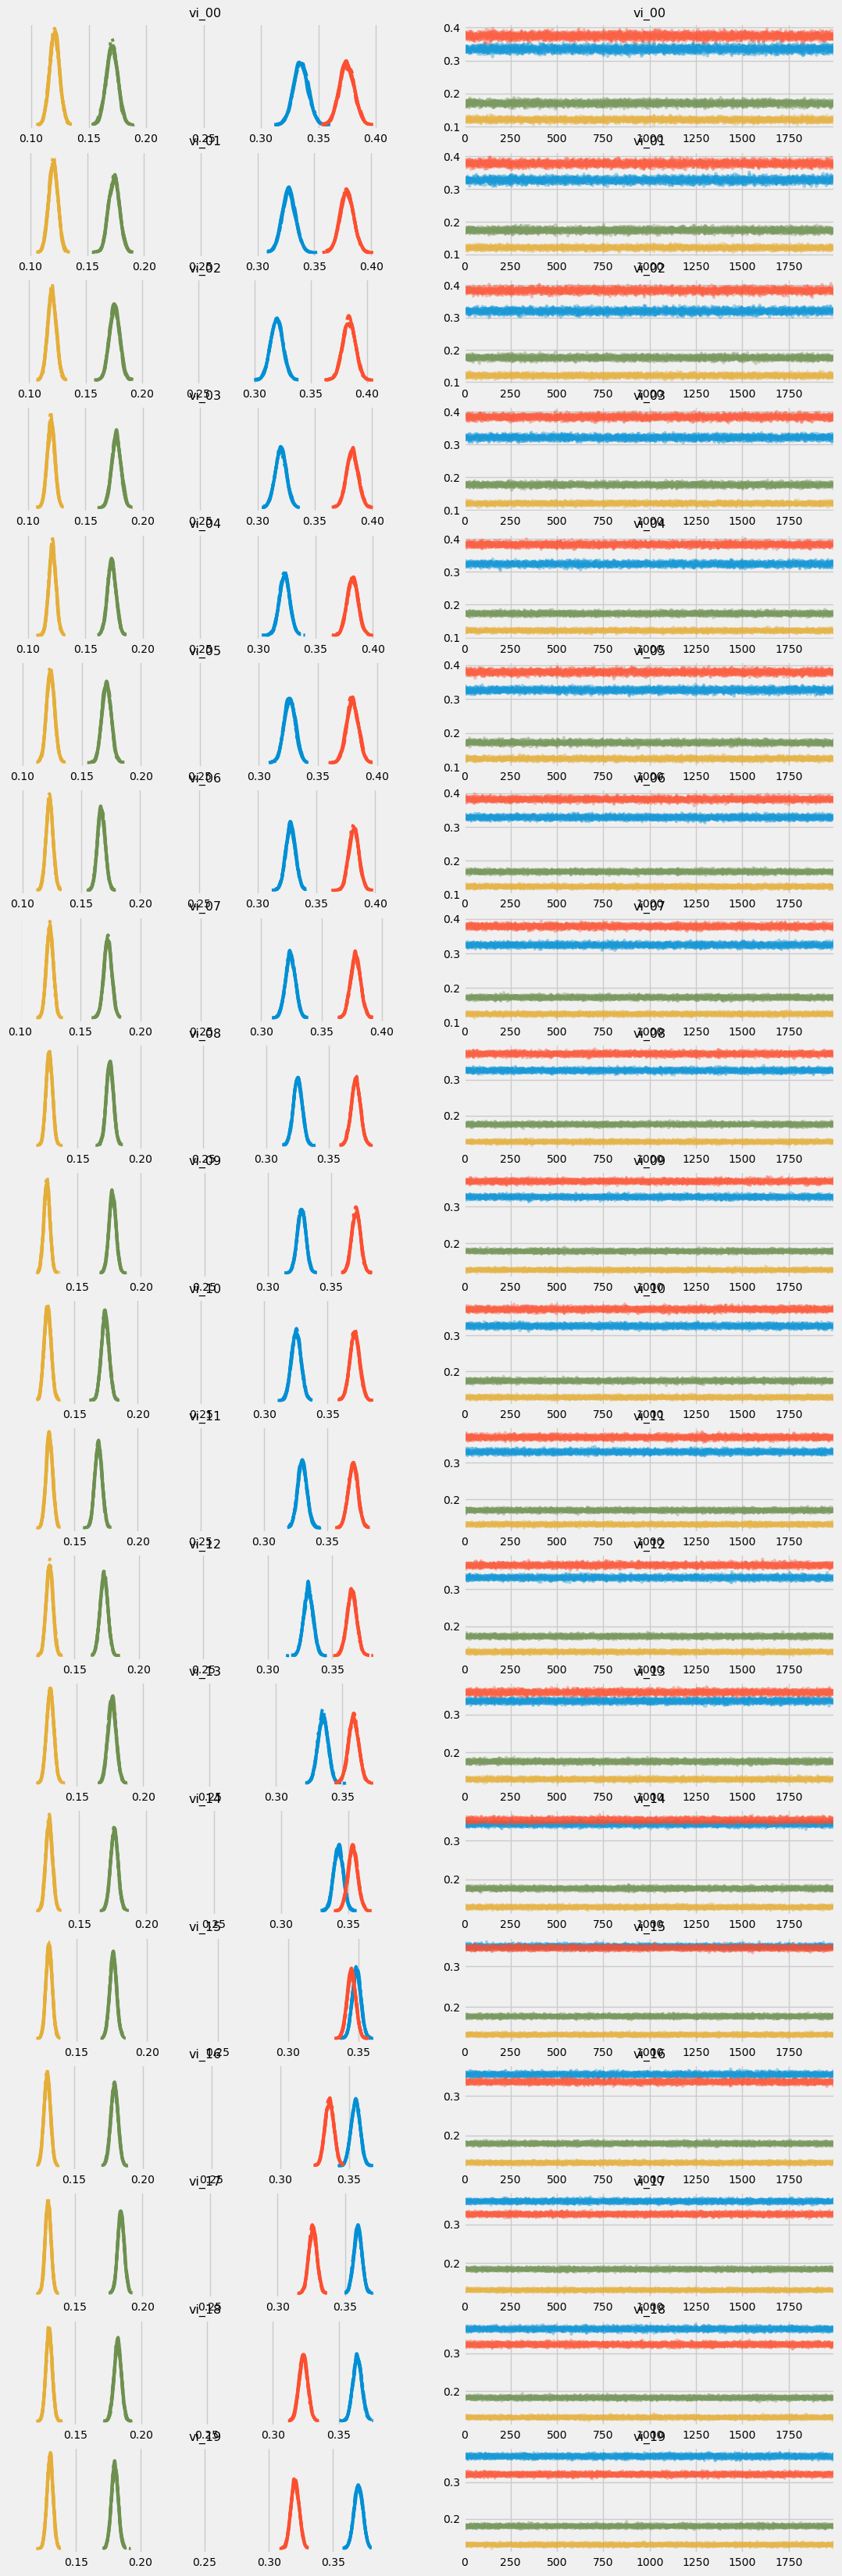

In [9]:
class SampleSettings(TypedDict):
    """The settings for the Bayesian model."""

    draws: int
    tune: int
    cores: int
    chains: int
    nuts_sampler: str
    nuts: NotRequired[dict[str, Any]]  # Requires Python 3.11


def sampler_settings() -> SampleSettings:
    """Return the settings for sampling."""

    core_chains = 5
    settings: SampleSettings = {
        "draws": 2_000,  # number of samples per core
        "tune": 3_000,  # number of tuning steps per core
        "cores": core_chains,
        "chains": core_chains,
        "nuts_sampler": "numpyro",
    }

    return settings


def run_run() -> tuple[az.InferenceData, str]:
    """Fit the data to the model. Return the inference data
    and a string identifying where glitches may have occurred
    in the sampling process."""

    sampling = sampler_settings()
    idata, glitches = bayes_tools.draw_samples(model, **sampling)

    return idata, glitches


inference, problems = run_run()

## Charts

In [10]:
@cache
def _get_var(var_name: str) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    return (
        az.extract(inference, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=2)
        .T
    )

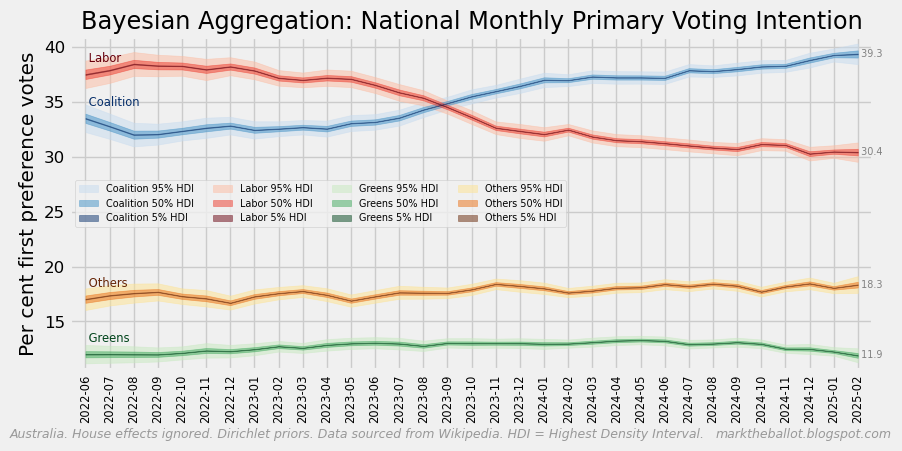

In [11]:
def plot_results() -> None:
    """Plot the aggregated primary voting intention results."""

    parties = ["Coalition", "Labor", "Greens", "Others"]
    percents = [2.5, 25, 47.5]
    start_month = pd.Period(P["simplex_nat_vi"].index.min(), freq="M")

    intensities = [
        (p - min(percents)) / (max(percents) - min(percents)) for p in percents
    ]
    min_intensity = 0.25
    intensity_fracs = [c * (1.0 - min_intensity) + min_intensity for c in intensities]

    _fig, ax = plt.subplots()
    for party in parties:
        palette = {
            "Coalition": "Blues",
            "Labor": "Reds",
            "Greens": "Greens",
            "Others": "YlOrBr",
        }[party]
        color = plt.get_cmap(palette)

        for i, p in enumerate(percents):
            quants = p, 100 - p
            label = f"{party} {quants[1] - quants[0]:0.0f}% HDI"

            x, y1, y2 = [], [], []
            for month in range(P["n_months"]):
                vi = _get_var(f"{VI_PREFIX}{month:02}").T
                vi.columns = pd.Index(parties)

                lower, upper = [vi[party].quantile(q=q / 100.0) for q in quants]
                x.append(str(start_month + month))
                y1.append(lower * 100)
                y2.append(upper * 100)

            intensity = intensity_fracs[i]
            ax.fill_between(
                x=x,  # type: ignore[arg-type]
                y1=y1,
                y2=y2,
                color=color(intensity),
                alpha=0.5,
                label=label,
                zorder=i + 1,
            )
        ax.text(
            x=x[-1],  # type: ignore[arg-type]
            y=y2[-1],
            s=f" {(y2[-1]+y1[-1])/2:.1f}",
            va="center",
            ha="left",
            color="gray",
            fontsize="xx-small",
        )
        ax.text(
            x=x[0],  # type: ignore[arg-type]
            y=y2[0]+0.8,
            s=f" {party}",
            va="bottom",
            ha="left",
            color=color(intensity_fracs[-1]),
            fontsize="x-small",
        )

    ax.tick_params(axis="x", rotation=90, labelsize="x-small")
    plotting.finalise_plot(
        ax,
        title="Bayesian Aggregation: National Monthly Primary Voting Intention",
        ylabel="Per cent first preference votes",
        legend={"loc": "center left", "fontsize": "xx-small", "ncol": 4},
        lfooter="Australia. House effects ignored. Dirichlet priors. "
        + "Data sourced from Wikipedia. HDI = Highest Density Interval.",
        rfooter="marktheballot.blogspot.com",
        rheader=problems if problems else None,
        show=True,
    )


plot_results()

## Finished

In [12]:
print("Finished")

Finished
